In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset

%load_ext autoreload
%autoreload 2

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Get dataset

In [5]:
DATA_PATH = "./wiki_data.csv"

In [6]:
dataset = Dataset(DATA_PATH)
dictionary = dataset.get_dictionary()

In [7]:
print(dataset.get_possible_modalities())

{'@word', '@bigram'}


### Make initial model

In [8]:
from topicnet.cooking_machine.model_constructor import init_simple_default_model

n_topics = 35
n_background = 0
model_artm = init_simple_default_model(
    dataset=dataset,
    modalities_to_use={'@word'},#dataset.get_possible_modalities(),
    main_modality='@word',
    specific_topics=n_topics - n_background,
    background_topics=n_background,
)
specific_topics, bacground_topics = model_artm.topic_names[:-n_background], model_artm.topic_names[-n_background:]
model_artm.scores

[PerplexityScore@all, SparsityThetaScore, SparsityPhiScore@word, PerplexityScore@word, TopicKernel@word]

In [9]:
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name="thetha_smooth",
                                                              topic_names=specific_topics))

In [10]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name="phi_smooth",
                                                       topic_names=specific_topics))

### Define Topic Model

In [11]:
model = TopicModel(model_artm, model_id='LDA_DEMO')

### Define experiment

In [12]:
from topicnet.cooking_machine.experiment import Experiment
experiment = Experiment(experiment_id='LDA_DEMO', save_path='LDA_DEMO', topic_model=model)

## Cube

In [13]:
cube1 = RegularizersModifierCube(
    num_iter=10,
    tracked_score_function=retrieve_score_for_strategy('PerplexityScore@all'),
    regularizer_parameters=[{
        'name': "thetha_smooth",
        'tau_grid': [0.95, 1]
    },
    {
        'name': "phi_smooth",
        'tau_grid': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
    }],
    reg_search='grid',
    relative_coefficients=False,
    verbose=True
)

## Lets start learning

In [14]:
start_time = time.time()
models = cube1(model, dataset)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 12/12 [06:01<00:00, 30.12s/it]


--- 866.5887308120728 seconds ---


In [34]:
models_all = experiment.select(f'PerplexityScore@all -> min  COLLECT all')

In [35]:
model_best_perplexity = experiment.select(f'PerplexityScore@all -> min')

In [17]:
query = (
    "TopicKernel@word.average_contrast > 0.7 * MAXIMUM(TopicKernel@word.average_contrast) "
    "and TopicKernel@word.average_purity > 0.7 * MAXIMUM(TopicKernel@word.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
)
model_best = experiment.select(query)
models_best = experiment.select(query + " COLLECT all")

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/routine.py:522: UserWarning: Can't return the requested number of models:  "12". Only "2" satisfy the query
  W_RETURN_FEWER_MODELS_DETAILS.format(models_num, len(result_models)))


In [18]:
model_best_perplexity

In [19]:
from IPython.core.display import display, HTML


display(HTML("""<style>
div.output_html {  
    white-space: nowrap;  
}
div .output_subarea > pre {  
    white-space: pre;  
    word-wrap: normal;  
}
</style>"""))

In [20]:
experiment.show()

Experiment LDA_DEMO

Experiment was made with BigARTM 0.9.0
Tree:
                            ┌##22h25m13s_07d11m2019y###
                            ├##22h25m44s_07d11m2019y###
                            ├##22h26m14s_07d11m2019y###
                            ├##22h26m44s_07d11m2019y###
                            ├##22h27m14s_07d11m2019y###
                            ├##22h27m44s_07d11m2019y###
<<<<<<<<<<<root>>>>>>>>>>>──┤
                            ├##22h28m14s_07d11m2019y###
                            ├##22h28m45s_07d11m2019y###
                            ├##22h29m15s_07d11m2019y###
                            ├##22h29m45s_07d11m2019y###
                            ├##22h30m15s_07d11m2019y###
                            └##22h30m45s_07d11m2019y###
Cubes:
 START                      | REG_MODIFIER              
                            |                           
 name:                      | tau_grid:                 
   ARTM                     |   0.95,                 

In [21]:
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

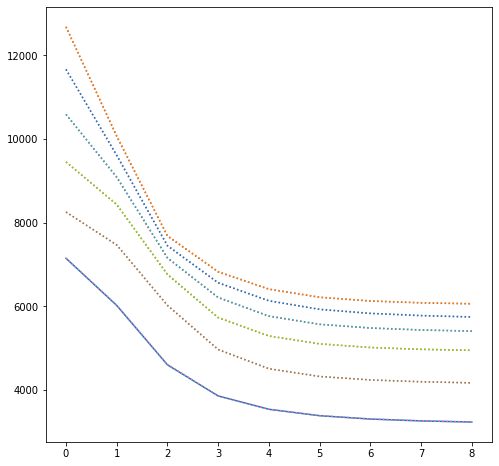

In [22]:
from matplotlib import cm

tms = experiment.models
n=len(tms)
colors = np.linspace(0, 0.65, n)
#tm = model_best

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    perp_score = tm.scores['PerplexityScore@all']
    ls = "-" if tm.model_id == model_best[0].model_id else ":"
    plt.plot(perp_score[1:], ls=ls)
plt.show()

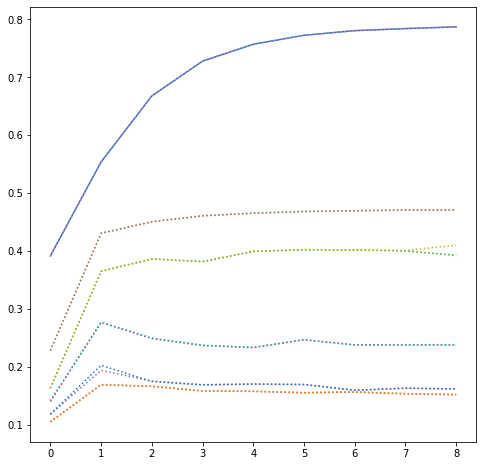

In [23]:
tms = experiment.models
n=len(tms)
colors = np.linspace(0, 0.65, n)

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    perp_score = tm.scores["TopicKernel@word.average_contrast"]
    ls = "-" if tm.model_id == model_best[0].model_id else ":"
    plt.plot(perp_score[1:], ls=ls)
plt.show()

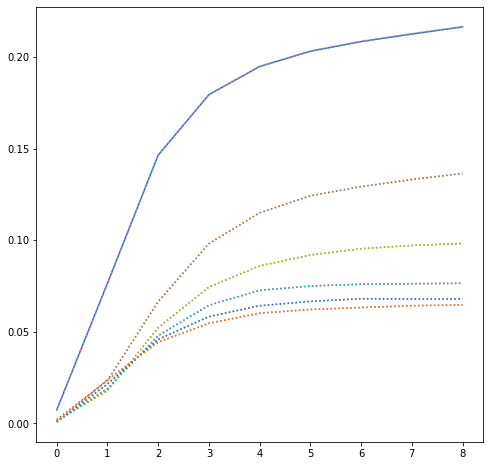

In [24]:
tms = experiment.models
n=len(tms)
colors = np.linspace(0, 0.65, n)

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    perp_score = tm.scores["TopicKernel@word.average_purity"]
    ls = "-" if tm.model_id == model_best[0].model_id else ":"
    plt.plot(perp_score[1:], ls=ls)
plt.show()

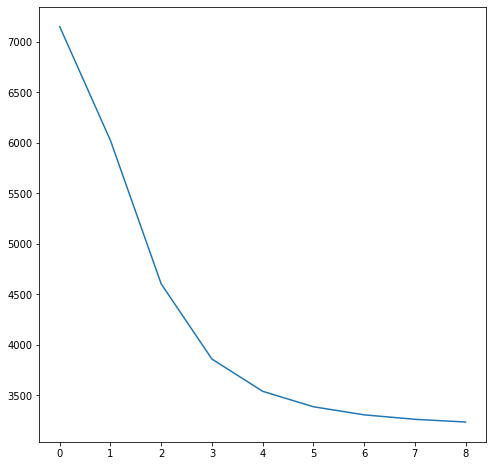

In [25]:
from matplotlib import cm
tm = model_best[0]

plt.figure(figsize=(8,8))
perp_score = tm.scores['PerplexityScore@all']
plt.plot(perp_score[1:])
plt.show()

In [26]:
def describe_model(model):
    print(model.model_id)
    for reg_name, reg in model.regularizers._data.items():
        print(reg_name, reg.tau)
    print(model.scores["PerplexityScore@all"][-1])
    print(model.scores["TopicKernel@word.average_contrast"][-1])
    print(model.scores["TopicKernel@word.average_purity"][-1])
    print("------")

In [27]:
model_best[0].model_id

'##22h25m13s_07d11m2019y###'

In [28]:
for model in models:
    describe_model(model)

##22h25m13s_07d11m2019y###
thetha_smooth 0.95
phi_smooth 0
3236.71435546875
0.7869000434875488
0.21641722321510315
------
##22h25m44s_07d11m2019y###
thetha_smooth 0.95
phi_smooth 0.2
4170.603515625
0.4707023501396179
0.13640953600406647
------
##22h26m14s_07d11m2019y###
thetha_smooth 0.95
phi_smooth 0.4
4949.2861328125
0.3926996886730194
0.09811945259571075
------
##22h26m44s_07d11m2019y###
thetha_smooth 0.95
phi_smooth 0.6
5407.9716796875
0.23827052116394043
0.07642961293458939
------
##22h27m14s_07d11m2019y###
thetha_smooth 0.95
phi_smooth 0.8
5745.33251953125
0.16209812462329865
0.06787566095590591
------
##22h27m44s_07d11m2019y###
thetha_smooth 0.95
phi_smooth 1.0
6061.74365234375
0.15213148295879364
0.06466551870107651
------
##22h28m14s_07d11m2019y###
thetha_smooth 1
phi_smooth 0
3238.586181640625
0.7871955037117004
0.2165207713842392
------
##22h28m45s_07d11m2019y###
thetha_smooth 1
phi_smooth 0.2
4174.380859375
0.4710267186164856
0.13641095161437988
------
##22h29m15s_07d11m201

In [29]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

In [30]:
thresh = 1e-5
first_model = TopTokensViewer(model_best[0], num_top_tokens=10, method='phi')

first_model_html =  first_model.to_html(first_model.view(),thresh=thresh)

In [31]:
for line in first_model_html:
    display_html(line, raw=True)

,topic_0 @word
p,0.00862
war,0.00811
army,0.00663
command,0.00636
battle,0.00631
general,0.00576
british,0.00563
nelson,0.00562
force,0.00548
ship,0.00443


,topic_1 @word
brown,0.01785
james,0.00769
work,0.00727
new,0.00616
time,0.00585
english,0.00523
year,0.00517
also,0.00498
translation,0.00445
erasmus,0.00429


,topic_2 @word
mary,0.01116
shelley,0.0076
elizabeth,0.00678
eugene,0.0059
muslim,0.00549
p,0.00508
muhammad,0.00499
burke,0.00489
abu,0.00481
fox,0.0045


,topic_3 @word
film,0.03465
award,0.01189
director,0.0086
best,0.00848
work,0.00644
also,0.00565
new,0.00448
direct,0.00438
make,0.00419
actor,0.00401


,topic_4 @word
constantine,0.01763
roman,0.00697
diocletian,0.0067
empire,0.00649
major,0.00642
emperor,0.00638
julian,0.00633
op,0.00633
barnes,0.00594
wk,0.00523


,topic_5 @word
kepler,0.0096
new,0.00663
hancock,0.00637
work,0.00526
philby,0.00503
year,0.00487
first,0.00481
publish,0.00421
also,0.00415
jay,0.00399


,topic_6 @word
state,0.00806
al,0.00641
u,0.00574
time,0.00502
party,0.00477
abu,0.00459
united,0.00459
government,0.00437
zubaydah,0.00433
labour,0.00394


,topic_7 @word
album,0.01388
music,0.01061
release,0.0098
film,0.00846
record,0.00844
song,0.00713
rock,0.00662
alfred,0.00658
hitchcock,0.00613
first,0.00539


,topic_8 @word
test,0.01225
bismarck,0.00711
first,0.00694
carnegie,0.00693
australia,0.00656
eisenhower,0.00642
one,0.0063
match,0.00556
muralitharan,0.00521
wicket,0.0051


,topic_9 @word
capp,0.00593
de,0.00568
new,0.00541
cook,0.00483
time,0.00465
voyage,0.00463
first,0.00444
one,0.00431
l,0.00411
life,0.00406


,topic_10 @word
win,0.01537
game,0.00987
year,0.0096
final,0.00831
play,0.0082
open,0.00817
player,0.00811
world,0.0077
time,0.00679
team,0.00629


,topic_11 @word
story,0.00925
francis,0.00581
tupper,0.00526
booth,0.00525
p,0.00502
write,0.00499
book,0.0048
chekhov,0.00475
year,0.00443
work,0.00442


,topic_12 @word
work,0.01195
music,0.00839
chopin,0.00735
piano,0.00538
composer,0.00498
de,0.00458
bruno,0.0045
also,0.00415
one,0.00398
life,0.00386


,topic_13 @word
state,0.00928
war,0.00871
government,0.0081
chamberlain,0.00521
thomas,0.00512
party,0.00501
united,0.00499
court,0.00479
would,0.00478
page,0.00478


,topic_14 @word
church,0.01326
st,0.01107
john,0.00984
christian,0.00923
saint,0.00864
god,0.00534
crick,0.00499
jesus,0.00496
book,0.00465
also,0.00446


,topic_15 @word
work,0.01566
art,0.00934
story,0.00695
life,0.00553
book,0.00547
new,0.00531
write,0.0051
painting,0.00469
publish,0.00458
year,0.00445


,topic_16 @word
bell,0.00869
moses,0.00657
anselm,0.00471
shah,0.00442
year,0.0044
first,0.00436
louis,0.00406
young,0.0037
also,0.00358
new,0.00341


,topic_17 @word
song,0.01345
album,0.00969
record,0.00944
blue,0.00715
music,0.00625
presley,0.00619
band,0.00557
release,0.00555
time,0.00504
show,0.00494


,topic_18 @word
university,0.01154
language,0.00674
work,0.00592
science,0.00463
new,0.00459
also,0.0045
state,0.00444
theory,0.00419
press,0.00363
book,0.00362


,topic_19 @word
roman,0.01389
life,0.00861
emperor,0.00774
nero,0.00755
rome,0.0072
history,0.00611
claudius,0.00564
caligula,0.00543
also,0.00472
tacitus,0.00463


,topic_20 @word
fiction,0.01047
science,0.0084
story,0.00723
book,0.00675
oswald,0.00657
isbn,0.00597
novel,0.00552
lewis,0.00545
write,0.00526
world,0.00503


,topic_21 @word
armstrong,0.00771
ford,0.00755
work,0.00644
first,0.00588
wallace,0.0051
year,0.00464
darwin,0.00448
use,0.00439
one,0.00434
company,0.00426


,topic_22 @word
theory,0.01219
science,0.00821
university,0.00656
work,0.00625
study,0.00505
scientific,0.00495
peirce,0.00491
einstein,0.00485
book,0.00467
one,0.00464


,topic_23 @word
king,0.01726
henry,0.01006
son,0.00708
louis,0.00693
charles,0.00659
england,0.00522
duke,0.00494
ii,0.00489
france,0.00456
de,0.00455


,topic_24 @word
work,0.00822
wright,0.00777
design,0.00652
house,0.00564
also,0.00561
aristotle,0.00558
one,0.0043
first,0.00422
building,0.00418
use,0.00407


,topic_25 @word
jordan,0.00812
hitler,0.00715
göring,0.00606
schwarzenegger,0.00591
warhol,0.00572
goebbels,0.00546
time,0.00528
new,0.00507
hoover,0.0046
would,0.00419


,topic_26 @word
hegel,0.00838
work,0.00655
university,0.00647
tolkien,0.00593
ibn,0.00575
philosophy,0.00524
al,0.00511
medicine,0.00459
also,0.0043
press,0.00425


,topic_27 @word
emperor,0.01387
tesla,0.01056
robeson,0.01054
p,0.00794
imperial,0.00757
paul,0.00755
year,0.00637
daughter,0.00513
prince,0.0051
rodin,0.00479


,topic_28 @word
de,0.005
nicholas,0.00488
goldman,0.00475
russia,0.00462
franco,0.00458
alexander,0.00457
calvin,0.00412
first,0.00406
year,0.00403
war,0.00351


,topic_29 @word
trotsky,0.00803
rousseau,0.00705
lynch,0.00602
david,0.00568
joyce,0.00536
party,0.00525
soviet,0.00524
new,0.00475
would,0.00376
become,0.0037


,topic_30 @word
film,0.0103
show,0.00707
award,0.00693
role,0.00614
star,0.0058
also,0.00569
day,0.00558
tv,0.00535
television,0.00531
series,0.00518


,topic_31 @word
rommel,0.00833
force,0.00647
army,0.00631
augustus,0.00617
montgomery,0.00613
elijah,0.0059
carson,0.00566
battle,0.00523
p,0.00434
war,0.00429


,topic_32 @word
party,0.00607
first,0.00544
kemp,0.00518
president,0.00516
soviet,0.00481
minister,0.00477
year,0.00458
one,0.00446
government,0.00444
reagan,0.00425


,topic_33 @word
work,0.01034
philosophy,0.00763
also,0.0051
russell,0.00463
life,0.00445
one,0.00385
time,0.00374
write,0.00369
p,0.00364
de,0.00363


,topic_34 @word
novel,0.00919
de,0.00825
work,0.00811
write,0.0059
book,0.00584
poem,0.00581
life,0.00556
publish,0.00476
austen,0.00467
isbn,0.0042


In [32]:

from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
last_model_top_doc = TopDocumentsViewer(model_best[0], dataset=dataset).view()

In [37]:
n=7
for line, topic_docs in list(zip(first_model_html, last_model_top_doc)):
    display_html(line, raw=True)
    display(topic_docs)

,topic_0 @word
p,0.00862
war,0.00811
army,0.00663
command,0.00636
battle,0.00631
general,0.00576
british,0.00563
nelson,0.00562
force,0.00548
ship,0.00443


['Horatio_Nelson,_1st_Viscount_Nelson',
 'Harold_Alexander,_1st_Earl_Alexander_of_Tunis',
 'Arthur_Wellesley,_1st_Duke_of_Wellington',
 'Isoroku_Yamamoto',
 'John_Jellicoe,_1st_Earl_Jellicoe',
 'David_Beatty,_1st_Earl_Beatty',
 'John_Paul_Jones',
 'Claude_Auchinleck',
 'Arthur_Phillip',
 'Aurangzeb']

,topic_1 @word
brown,0.01785
james,0.00769
work,0.00727
new,0.00616
time,0.00585
english,0.00523
year,0.00517
also,0.00498
translation,0.00445
erasmus,0.00429


['James_Beard',
 'Jules_Verne',
 'Charles_Baudelaire',
 'Claude_Monet',
 'John_Keats',
 'Fyodor_Dostoyevsky',
 'Julia_Child',
 'James_Brown',
 'Ogden_Nash',
 'Gustave_Flaubert']

,topic_2 @word
mary,0.01116
shelley,0.0076
elizabeth,0.00678
eugene,0.0059
muslim,0.00549
p,0.00508
muhammad,0.00499
burke,0.00489
abu,0.00481
fox,0.0045


['Abu_Bakr',
 'Aisha',
 'Mary_Shelley',
 'Osman_I',
 'George_Fox',
 'Ahmed_III',
 'Mary_Wollstonecraft',
 'Edmund_Burke',
 'Murad_IV',
 'Mehmed_III']

,topic_3 @word
film,0.03465
award,0.01189
director,0.0086
best,0.00848
work,0.00644
also,0.00565
new,0.00448
direct,0.00438
make,0.00419
actor,0.00401


['Coen_brothers',
 'Martin_Scorsese',
 'Akira_Kurosawa',
 'James_Cameron',
 'Hayao_Miyazaki',
 'Dave_Winer',
 'Kabir_Bedi',
 'Alvar_Aalto',
 'Jack_Lemmon',
 'Don_Rosa']

,topic_4 @word
constantine,0.01763
roman,0.00697
diocletian,0.0067
empire,0.00649
major,0.00642
emperor,0.00638
julian,0.00633
op,0.00633
barnes,0.00594
wk,0.00523


['Carl_Friedrich_Abel',
 'Constantine_the_Great',
 'Diocletian',
 'Constantius_II',
 'Julian_(emperor)',
 'Fernando_Pessoa',
 'Edward_Elgar',
 'Elagabalus',
 'Constans',
 'Chris_Marker']

,topic_5 @word
kepler,0.0096
new,0.00663
hancock,0.00637
work,0.00526
philby,0.00503
year,0.00487
first,0.00481
publish,0.00421
also,0.00415
jay,0.00399


['Johannes_Kepler',
 'John_Hancock',
 'Italo_Calvino',
 'Kim_Philby',
 'Gerolamo_Cardano',
 'Filippo_Tommaso_Marinetti',
 'Margaret_Mead',
 'Luca_Pacioli',
 'Amos_Bronson_Alcott',
 'Kim_Stanley_Robinson']

,topic_6 @word
state,0.00806
al,0.00641
u,0.00574
time,0.00502
party,0.00477
abu,0.00459
united,0.00459
government,0.00437
zubaydah,0.00433
labour,0.00394


['Abu_Zubaydah',
 'Nawaf_al-Hazmi',
 'Hani_Hanjour',
 'Josip_Broz_Tito',
 'Sara_Jane_Olson',
 'Francisco_I',
 'Ahmed_al-Nami',
 'Majed_Moqed',
 'Abdulaziz_al-Omari',
 'Enver_Hoxha']

,topic_7 @word
album,0.01388
music,0.01061
release,0.0098
film,0.00846
record,0.00844
song,0.00713
rock,0.00662
alfred,0.00658
hitchcock,0.00613
first,0.00539


['Amr_Diab',
 'Miles_Davis',
 'Kid_Rock',
 'Enya',
 'Jennifer_Lopez',
 'Jeff_Mills',
 'Garth_Brooks',
 'Elvis_Costello',
 'Egyptian_Lover',
 'Joe_Pass']

,topic_8 @word
test,0.01225
bismarck,0.00711
first,0.00694
carnegie,0.00693
australia,0.00656
eisenhower,0.00642
one,0.0063
match,0.00556
muralitharan,0.00521
wicket,0.0051


['Muttiah_Muralitharan',
 'Brian_Lara',
 'Hansie_Cronje',
 'Ian_Botham',
 'Diego_de_Almagro',
 'Moctezuma_I',
 'Cem_Karaca',
 'Moctezuma_II',
 'Andrew_Carnegie',
 'Mick_Doohan']

,topic_9 @word
capp,0.00593
de,0.00568
new,0.00541
cook,0.00483
time,0.00465
voyage,0.00463
first,0.00444
one,0.00431
l,0.00411
life,0.00406


['Al_Capp',
 'Gustave_Eiffel',
 'Michel_Tremblay',
 'Blackbeard',
 'James_Cook',
 'André_Gide',
 'Ferdinand_Magellan',
 'Anaïs_Nin',
 'Naomi_Wolf',
 'Marcel_Achard']

,topic_10 @word
win,0.01537
game,0.00987
year,0.0096
final,0.00831
play,0.0082
open,0.00817
player,0.00811
world,0.0077
time,0.00679
team,0.00629


['Björn_Borg',
 'Martina_Hingis',
 'Anna_Kournikova',
 'Andre_Agassi',
 'Patrick_Rafter',
 'Johan_Cruyff',
 'Bobby_Charlton',
 'Gheorghe_Hagi',
 'Gordon_Banks',
 'Geoff_Hurst']

,topic_11 @word
story,0.00925
francis,0.00581
tupper,0.00526
booth,0.00525
p,0.00502
write,0.00499
book,0.0048
chekhov,0.00475
year,0.00443
work,0.00442


['Anton_Chekhov',
 'John_Wilkes_Booth',
 'John_Steinbeck',
 'Fritz_Leiber',
 'August_Derleth',
 'Edward_Plunkett,_18th_Baron_of_Dunsany',
 'Nostradamus',
 'Clark_Ashton_Smith',
 'Francis_Xavier',
 'Boston_Corbett']

,topic_12 @word
work,0.01195
music,0.00839
chopin,0.00735
piano,0.00538
composer,0.00498
de,0.00458
bruno,0.0045
also,0.00415
one,0.00398
life,0.00386


['Frédéric_Chopin',
 'Gian_Lorenzo_Bernini',
 'Fra_Angelico',
 'Caravaggio',
 'Francesco_Borromini',
 'Franz_Schmidt',
 'Giordano_Bruno',
 'Galeazzo_Alessi',
 'Claude_Debussy',
 'Fra_Bartolomeo']

,topic_13 @word
state,0.00928
war,0.00871
government,0.0081
chamberlain,0.00521
thomas,0.00512
party,0.00501
united,0.00499
court,0.00479
would,0.00478
page,0.00478


['Neville_Chamberlain',
 'Clarence_Thomas',
 'Deng_Xiaoping',
 'Daniel_Ortega',
 'Joseph_McCarthy',
 'Charles_Evans_Hughes',
 'John_Danforth',
 'Mackenzie_Bowell',
 'John_Engler',
 'Alexander_Mackenzie']

,topic_14 @word
church,0.01326
st,0.01107
john,0.00984
christian,0.00923
saint,0.00864
god,0.00534
crick,0.00499
jesus,0.00496
book,0.00465
also,0.00446


['Irenaeus',
 'Barnabas',
 'John_Chrysostom',
 'Benedict_of_Nursia',
 'Columbanus',
 'John_the_Evangelist',
 'Matthew_the_Apostle',
 'Cyril_of_Alexandria',
 'Cyril_of_Jerusalem',
 'Jerome']

,topic_15 @word
work,0.01566
art,0.00934
story,0.00695
life,0.00553
book,0.00547
new,0.00531
write,0.0051
painting,0.00469
publish,0.00458
year,0.00445


['Edvard_Munch',
 'Kurt_Schwitters',
 'Franz_Kafka',
 'Charles_Dickens',
 'Jack_Kirby',
 'Jorge_Luis_Borges',
 'Kathy_Acker',
 'Louise_Erdrich',
 'Gary_Snyder',
 'Jean-François_Millet']

,topic_16 @word
bell,0.00869
moses,0.00657
anselm,0.00471
shah,0.00442
year,0.0044
first,0.00436
louis,0.00406
young,0.0037
also,0.00358
new,0.00341


['Louis_Leakey',
 'Moses',
 'Marie_Curie',
 'Anselm_of_Canterbury',
 'Alexander_Graham_Bell',
 'Kathleen_Kenyon',
 'Ahmad_Shah_Durrani',
 'Mason_Remey',
 'Brigham_Young',
 'Alexander_Fleming']

,topic_17 @word
song,0.01345
album,0.00969
record,0.00944
blue,0.00715
music,0.00625
presley,0.00619
band,0.00557
release,0.00555
time,0.00504
show,0.00494


['John_Lee_Hooker',
 'Bo_Diddley',
 'Elvis_Presley',
 'Keith_Moon',
 'Blind_Lemon_Jefferson',
 'Juliana_Hatfield',
 'Joni_Mitchell',
 'Ani_DiFranco',
 'Ed_Sullivan',
 'Gloria_Gaynor']

,topic_18 @word
university,0.01154
language,0.00674
work,0.00592
science,0.00463
new,0.00459
also,0.0045
state,0.00444
theory,0.00419
press,0.00363
book,0.00362


['Murray_Rothbard',
 'Joseph_Schumpeter',
 'Joseph_Greenberg',
 'Milton_Friedman',
 'Friedrich_Hayek',
 'Donald_Knuth',
 'Clement_Martyn_Doke',
 'Jürgen_Habermas',
 'Eugene_Wigner',
 'George_Washington_Carver']

,topic_19 @word
roman,0.01389
life,0.00861
emperor,0.00774
nero,0.00755
rome,0.0072
history,0.00611
claudius,0.00564
caligula,0.00543
also,0.00472
tacitus,0.00463


['Caligula',
 'Nero',
 'Claudius',
 'Domitian',
 'Agrippina_the_Elder',
 'Antoninus_Pius',
 'Marcus_Aurelius',
 'Galba',
 'Josephus',
 'Gnaeus_Julius_Agricola']

,topic_20 @word
fiction,0.01047
science,0.0084
story,0.00723
book,0.00675
oswald,0.00657
isbn,0.00597
novel,0.00552
lewis,0.00545
write,0.00526
world,0.00503


['Lee_Harvey_Oswald',
 'Jack_L',
 'Donald_A',
 'J',
 'Frederik_Pohl',
 'A',
 'Cyril_M',
 'Bud_Spencer',
 'Buckminster_Fuller',
 'Craig_Venter']

,topic_21 @word
armstrong,0.00771
ford,0.00755
work,0.00644
first,0.00588
wallace,0.0051
year,0.00464
darwin,0.00448
use,0.00439
one,0.00434
company,0.00426


['Neil_Armstrong',
 'Edwin_Howard_Armstrong',
 'Kelly_Johnson_(engineer)',
 'Henry_Ford',
 'Irving_Langmuir',
 'Alan_Turing',
 'Charles_Lyell',
 'Dale_Earnhardt',
 'John_Ambrose_Fleming',
 'Alfred_Russel_Wallace']

,topic_22 @word
theory,0.01219
science,0.00821
university,0.00656
work,0.00625
study,0.00505
scientific,0.00495
peirce,0.00491
einstein,0.00485
book,0.00467
one,0.00464


['Michael_Atiyah',
 'Charles_Sanders_Peirce',
 'Franz_Boas',
 'Karl_Popper',
 'Bjørn_Lomborg',
 'Albert_Einstein',
 'Mortimer_J',
 'Konrad_Lorenz',
 'John_Stuart_Mill',
 'Benoit_Mandelbrot']

,topic_23 @word
king,0.01726
henry,0.01006
son,0.00708
louis,0.00693
charles,0.00659
england,0.00522
duke,0.00494
ii,0.00489
france,0.00456
de,0.00455


['Louis_the_Pious',
 'Malcolm_III_of_Scotland',
 'Macbeth,_King_of_Scotland',
 'Casimir_II_the_Just',
 'Andrew_II_of_Hungary',
 'Henry_VII_of_England',
 'Casimir_III_the_Great',
 'Charlemagne',
 'Louis_XIV_of_France',
 'Mindaugas']

,topic_24 @word
work,0.00822
wright,0.00777
design,0.00652
house,0.00564
also,0.00561
aristotle,0.00558
one,0.0043
first,0.00422
building,0.00418
use,0.00407


['Frank_Lloyd_Wright',
 'Archimedes',
 'Michael_Faraday',
 'Ole_Rømer',
 'Alessandro_Volta',
 'Henry_Moseley',
 'Oliver_Heaviside',
 'Abdülaziz',
 'Aristotle',
 'Augustin-Jean_Fresnel']

,topic_25 @word
jordan,0.00812
hitler,0.00715
göring,0.00606
schwarzenegger,0.00591
warhol,0.00572
goebbels,0.00546
time,0.00528
new,0.00507
hoover,0.0046
would,0.00419


['Joseph_Goebbels',
 'Hermann_Göring',
 'Fiorello_H',
 'Helen_Gandy',
 'Abd_al-Rahman_I',
 'Arnold_Schwarzenegger',
 'Michael_Jordan',
 'Mikhail_Kalashnikov',
 'Fridtjof_Nansen',
 'J']

,topic_26 @word
hegel,0.00838
work,0.00655
university,0.00647
tolkien,0.00593
ibn,0.00575
philosophy,0.00524
al,0.00511
medicine,0.00459
also,0.0043
press,0.00425


['Avicenna',
 'Confucius',
 'Nichiren',
 'Muhammad_ibn_Abd_al-Wahhab',
 'Galen',
 'Georg_Wilhelm_Friedrich_Hegel',
 'Li_Bai',
 'Alexis_Carrel',
 'Johann_Gottlieb_Fichte',
 'Alois_Alzheimer']

,topic_27 @word
emperor,0.01387
tesla,0.01056
robeson,0.01054
p,0.00794
imperial,0.00757
paul,0.00755
year,0.00637
daughter,0.00513
prince,0.0051
rodin,0.00479


['Emperor_Uda',
 'Emperor_Seiwa',
 'Emperor_Saga',
 'Emperor_Montoku',
 'Emperor_Tenmu',
 'Emperor_Kazan',
 'Emperor_Junna',
 'Emperor_Monmu',
 'Emperor_Junnin',
 'Empress_Suiko']

,topic_28 @word
de,0.005
nicholas,0.00488
goldman,0.00475
russia,0.00462
franco,0.00458
alexander,0.00457
calvin,0.00412
first,0.00406
year,0.00403
war,0.00351


['Nicholas_II_of_Russia',
 'Huldrych_Zwingli',
 'Maria_Feodorovna_(Dagmar_of_Denmark)',
 'Alfonso_XIII_of_Spain',
 'E',
 'Alexander_III_of_Russia',
 'Alfonso_XII_of_Spain',
 'Emma_Goldman',
 'John_Calvin',
 'Alexander_I_of_Russia']

,topic_29 @word
trotsky,0.00803
rousseau,0.00705
lynch,0.00602
david,0.00568
joyce,0.00536
party,0.00525
soviet,0.00524
new,0.00475
would,0.00376
become,0.0037


['Leon_Trotsky',
 'Lavrentiy_Beria',
 'Jacques-Louis_David',
 'Nikolai_Bukharin',
 'James_Joyce',
 'Jean-Jacques_Rousseau',
 'Indira_Gandhi',
 'Karl_Radek',
 'Federico_Fellini',
 'Gyula_Andrássy']

,topic_30 @word
film,0.0103
show,0.00707
award,0.00693
role,0.00614
star,0.0058
also,0.00569
day,0.00558
tv,0.00535
television,0.00531
series,0.00518


['Denis_Leary',
 'Michael_Palin',
 'Joshua_Jackson',
 'Kelsey_Grammer',
 'Chuck_Jones',
 'Mel_Brooks',
 'Kyle_MacLachlan',
 'Cary_Elwes',
 'David_Janssen',
 'Doris_Day']

,topic_31 @word
rommel,0.00833
force,0.00647
army,0.00631
augustus,0.00617
montgomery,0.00613
elijah,0.0059
carson,0.00566
battle,0.00523
p,0.00434
war,0.00429


['Erwin_Rommel',
 'Bernard_Montgomery,_1st_Viscount_Montgomery_of_Alamein',
 'Kit_Carson',
 'Louis_Andriessen',
 'Elijah',
 'Alexios_I_Komnenos',
 'Augustus',
 'Ahmad_Shah_Massoud',
 'Jacques_Lacan',
 'Andronikos_I_Komnenos']

,topic_32 @word
party,0.00607
first,0.00544
kemp,0.00518
president,0.00516
soviet,0.00481
minister,0.00477
year,0.00458
one,0.00446
government,0.00444
reagan,0.00425


['Ariel_Sharon',
 'Jack_Kemp',
 'Mikhail_Gorbachev',
 'Menachem_Begin',
 'Michael_Schumacher',
 'Leszek_Miller',
 'Mary_Robinson',
 'Michael_Milken',
 'Abdul_Rashid_Dostum',
 'Nancy_Reagan']

,topic_33 @word
work,0.01034
philosophy,0.00763
also,0.0051
russell,0.00463
life,0.00445
one,0.00385
time,0.00374
write,0.00369
p,0.00364
de,0.00363


['Gilles_Deleuze',
 'Maurice_Merleau-Ponty',
 'Edmund_Husserl',
 'Baruch_Spinoza',
 'Morihei_Ueshiba',
 'Félix_Guattari',
 'Henri_Bergson',
 'G',
 'Jean-Paul_Sartre',
 'Epicurus']

,topic_34 @word
novel,0.00919
de,0.00825
work,0.00811
write,0.0059
book,0.00584
poem,0.00581
life,0.00556
publish,0.00476
austen,0.00467
isbn,0.0042


['Jane_Austen',
 'Gerard_Manley_Hopkins',
 'George_Eliot',
 'Miguel_de_Cervantes',
 'Rumi',
 'Charles_Williams_(British_writer)',
 'Nasreddin',
 'Charlotte_Brontë',
 'Elizabeth_Barrett_Browning',
 'Marquis_de_Sade']

Получившиеся топ-токены хорошо описывают темы и по качеству сравнимы с результатом авторов статьи ***Reading Tea Leaves: How Humans Interpret Topic Models*** (http://139.18.2.164/mroeder/palmetto/datasets/)